# Laplacian scale space representations

The concept of a scale space refers to a framework for working with a signal, in this case images, as a collection of signals each describing information at different length scales.

## Lab Homework: Laplacian Pyramid Computation

### Objective
In this homework assignment, we'll explore Laplacian pyramids, a powerful technique for image processing and multi-scale representation. Laplacian pyramids are particularly useful for image compression, blending, and feature extraction.

## Prerequisites
First, let's import our required libraries:

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import List, Tuple

## Part 1: Understanding the Building Blocks

### 1.1 Next Pyramid Layer Function
The following function computes the next layer of the pyramid. Study it carefully and answer the questions below.


In [4]:
def next_pyramid_layer(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the next layer of the Laplacian pyramid.
    
    Args:
        img: Input image array of shape (bands, height, width)
        
    Returns:
        tuple: (residual, downsampled)
            - residual: Difference between original and upsampled image
            - downsampled: Reduced resolution image
    """
    # Downsample each band
    down = np.stack([cv2.pyrDown(layer) for layer in img])
    
    # Upsample the downsampled image
    up = np.stack([cv2.pyrUp(layer) for layer in down])
    
    # Get original dimensions
    nr, nc = img.shape[1:]
    
    # Calculate residual (difference between original and upsampled)
    resid = img - up[:,:nr,:nc]
    
    return resid, down

### Questions for Part 1 (Not Graded): 
 1. Why do we need to use np.stack() when processing the image?  
  *-> To combine the individual image layers into a single array.*
 2. What is the purpose of slicing up[:,:nr,:nc]?  
  *-> To ensure that the upsampled image matches the original dimensions of the input image, as upsampling might result in an image that is slightly larger than the original (due to interpolation), so we need to crop it to match the original dimensions.*
 3. What would happen if we didn't match the dimensions in the subtraction?  
  *-> It would result in a dimension mismatch error.*

## Part 2: The Complete Pyramid

### 2.1 Laplacian Pyramid Function
Now let's examine the full pyramid construction:

In [5]:
def laplacian_pyramid(img: np.ndarray, max_layers: int = 100) -> List[np.ndarray]:
    """
    Compute Laplacian pyramid for a multiband image.
    
    Args:
        img: Input image array of shape (bands, height, width)
        max_layers: Maximum number of pyramid layers to compute
        
    Returns:
        list: Pyramid layers [residual1, residual2, ..., residualN, gaussian_remainder]
    """
    layers = []
    down = img
    prev_size = down.size
    
    for i in range(max_layers):
        resid, down = next_pyramid_layer(down)
        
        # Check if we've reached the smallest possible size
        if down.size == prev_size:
            break
            
        prev_size = down.size
        layers.append(resid)
    
    # Add the final Gaussian remainder
    layers.append(down)
    return layers

## Part 3: Practical Exercises

### Exercise 1: Basic Pyramid Construction
Complete the following code to build and visualize a Laplacian pyramid for the provided `image1.jpeg`:


In [7]:
def load_and_prepare_image(path: str) -> np.ndarray:
    """
    TODO: Write a function that:
    1. Loads an image using cv2.imread
    2. Converts it to floating point (0-1 range)
    3. Transposes it to (channel, height, width) order
    """
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (2, 0, 1)) # (bands, height, width)
    
    return img

In [12]:
def visualize_pyramid(pyramid: List[np.ndarray]) -> None:
    """
    TODO: Write a function that:
    1. Creates a figure with len(pyramid) subplots
    2. Displays each layer of the pyramid
    3. Shows the residual layers with a diverging colormap
    4. Shows the final Gaussian remainder in grayscale
    """
    num_layers = len(pyramid)
    
    ncols = 3
    nrows = (num_layers + 1) // ncols + 1
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    
    # Flatten axes array
    axes = axes.flatten()
    
    for i in range(num_layers):
        ax = axes[i]
        layer = pyramid[i]
        
        if i == num_layers - 1:  # Last layer is the Gaussian remainder (grayscale)
            ax.imshow(layer, cmap='gray')
            ax.set_title(f'Gaussian remainder (Layer {i+1})')
        else:  # Residual layers (diverging colormap)
            ax.imshow(layer, cmap='RdBu_r')
            ax.set_title(f'Residual (Layer {i+1})')
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


### Exercise 2: Pyramid Analysis

Write functions to answer the following questions:

In [19]:
def analyze_pyramid(pyramid: List[np.ndarray]) -> dict:
    """
    TODO: Create a function that returns a dictionary containing:
    1. The number of layers in the pyramid
    2. The size reduction ratio between consecutive layers
    3. The total memory usage of the pyramid vs. original image
    4. The amount of information (variance) in each residual layer
    """
    num_layers = len(pyramid)
    
    # Size reduction ratio between consecutive layers
    size_reduction_ratios = []
    for i in range(1, num_layers):
        prev_layer = pyramid[i - 1]
        curr_layer = pyramid[i]
        
        # Calculate the size reduction ratio (height, width)
        height_ratio = curr_layer.shape[1] / prev_layer.shape[1]
        width_ratio = curr_layer.shape[2] / prev_layer.shape[2]
        size_reduction_ratios.append((height_ratio, width_ratio))
    
    # Total memory usage of the pyramid vs. original image (in terms of number of pixels)
    original_size = pyramid[0].size
    pyramid_size = sum([layer.size for layer in pyramid])  # Total size of the pyramid
    memory_usage_ratio = pyramid_size / original_size
    
    # Variance in each residual layer
    variances = []
    for i in range(num_layers - 1):  # Exclude the final Gaussian remainder
        residual_layer = pyramid[i]
        variance = np.var(residual_layer)
        variances.append(variance)
    
    # Returning the analysis results
    return {
        "num_layers": num_layers,
        "size_reduction_ratios": size_reduction_ratios,
        "memory_usage_ratio": memory_usage_ratio,
        "variances": variances
    }

### Exercise 3: Image Reconstruction

In [25]:
def reconstruct_from_pyramid(pyramid: List[np.ndarray]) -> np.ndarray:
    """
    TODO: Write a function that:
    1. Takes a Laplacian pyramid as input
    2. Reconstructs the original image by reversing the pyramid operations
    3. Returns the reconstructed image
    
    Hint: You'll need to use cv2.pyrUp() and handle the dimensions carefully
    """
    # Starting with the last image in the pyramid (the Gaussian remainder)
    reconstructed_image = pyramid[-1]
    
    # looping in reverse order (from 2nd to last layer)
    for resid in reversed(pyramid[:-1]):
        upsampled_image = cv2.pyrUp(reconstructed_image)
        resid_resized = cv2.resize(resid, (upsampled_image.shape[1], upsampled_image.shape[0]))
        reconstructed_image = upsampled_image + resid_resized
    
    return reconstructed_image

## Submission Instructions

For this homework, please submit:
1. Your completed Python notebook with all exercises implemented
2. Example outputs using at least two different images

## Extra Credit
Implement one of the following:
1. Image blending using Laplacian pyramids
2. A modified pyramid structure that preserves color information better

Good luck!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07071395..1.2405316].


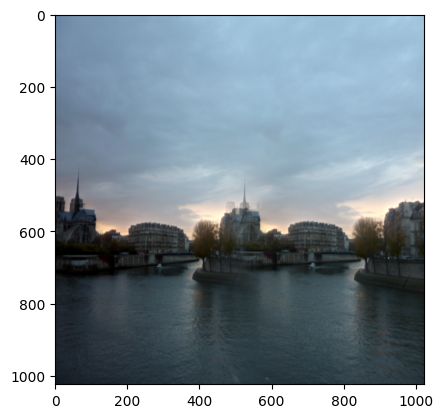

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3018608..1.076603].


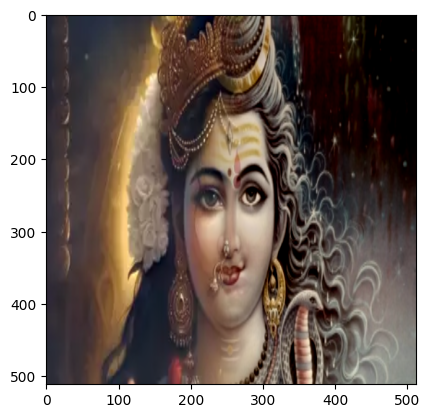

In [ ]:
# 1. Image blending using Laplacian pyramids
# function to create a mask
def create_mask(height: int, width: int) -> np.ndarray:
    x = np.zeros(int(7*width / 16))
    y = np.linspace(0, 1, int(width / 8))
    z = np.ones(int(7*width / 16))
    mask = np.concatenate([x, y, z])
    mask = np.tile(mask, (height, 1))
    return mask

# function to blend images
def blend_images(img1: np.ndarray, img2: np.ndarray, mask: np.ndarray, max_layers: int = 100) -> np.ndarray:
    img1 = img1.astype(np.float32) / 255.0
    img2 = img2.astype(np.float32) / 255.0
    mask = mask.astype(np.float32)

    # Convert the mask to the same size as the images
    mask_resized = cv2.resize(mask, (img1.shape[1], img1.shape[0]))

    # Check if mask is 2D and expand it to 3D (for color images)
    if len(mask_resized.shape) == 2:
        mask_resized = np.expand_dims(mask_resized, axis=-1)
        mask_resized = np.repeat(mask_resized, 3, axis=-1)
    
    # Generate Laplacian pyramids for both images
    lap_pyramid1 = laplacian_pyramid(img1, max_layers)
    lap_pyramid2 = laplacian_pyramid(img2, max_layers)
    
    # Generate Gaussian pyramids for the mask
    gauss_pyramid_mask = [mask_resized]
    for i in range(max_layers):
        mask_resized = cv2.pyrDown(mask_resized)
        gauss_pyramid_mask.append(mask_resized)
    
    # Blend the pyramids
    blended_pyramid = []
    for i in range(len(lap_pyramid1)):
        blended_resid = gauss_pyramid_mask[i] * lap_pyramid1[i] + (1 - gauss_pyramid_mask[i]) * lap_pyramid2[i]
        blended_pyramid.append(blended_resid)
    
    # Reconstruct the blended image
    blended_image = reconstruct_from_pyramid(blended_pyramid)
    
    return blended_image

# Load the images and mask
img1 = cv2.imread('paris_1a.jpg')
img2 = cv2.imread('paris_1b.jpg')

height, width = min(img1.shape[0], img2.shape[0]), min(img1.shape[1], img2.shape[1])

img1 = cv2.resize(img1, (width, height))
img2 = cv2.resize(img2, (width, height))
gradient_mask = create_mask(height, width)

# Blend the images
blended_image = blend_images(img1, img2, gradient_mask)
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.show()

# For other pair of images
img3 = cv2.imread('shiv.jpg')
img4 = cv2.imread('shakti.webp')

height1, width1 = min(img3.shape[0], img4.shape[0]), min(img3.shape[1], img4.shape[1])

img3 = cv2.resize(img3, (width1, height1))
img4 = cv2.resize(img4, (width1, height1))
gradient_mask = create_mask(height1, width1)

# Blend the images
blended_image1 = blend_images(img3, img4, gradient_mask)
plt.imshow(cv2.cvtColor(blended_image1, cv2.COLOR_BGR2RGB))
plt.show()